### Introduction

This notebook walks through all stages for the development of an AI image recoginition service using ML (a Convolutional Neural Network) and the CIFAR-10 dataset  

### Setup and Data Collection

In [1]:
#load dependencies and initialisations
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import warnings
import numpy as np
import tensorflow as tf 
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
gpus = tf.config.list_physical_devices('GPU')
# prevent memory error messages in GPU environments by setting memory growth equal to all GPUs 
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
model_filename = 'simple-cifar10.h5'

2023-07-22 08:54:28.564572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-22 08:54:28.620699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-22 08:54:28.620797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-22 08:54:28.622714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

1 Physical GPUs, 1 Logical GPUs


 /job:localhost/replica:0/task:0/device:GPU:0 with 2094 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [2]:
# Load CIFAR-10 dataset
keras.backend.set_image_data_format('channels_last')
dataset = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=True)

cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]
num_classes = len(cifar10_class_names)
print(f"Datasets Loaded.  Training: {x_train.shape[0]} images, Validation: {x_val.shape[0]} images Test: {x_test.shape[0]} images")  

Datasets Loaded.  Training: 40000 images, Validation: 10000 images Test: 10000 images


### Data Exploration

#### Data Summary

In [8]:
print(f"Training Set Size: {x_train.shape[0]} sample images")
print(f"Test Set Size: {x_test.shape[0]} sample images ")
targets = np.unique(y_train) 
print(f"No of classification classes: {num_classes}")
print(f"Classification Classes: { targets}");
print(f"Classification Class Names: {cifar10_class_names}");

Training Set Size: 40000 sample images
Test Set Size: 10000 sample images 
No of classification classes: 10
Classification Classes: [0 1 2 3 4 5 6 7 8 9]
Classification Class Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Data Preview

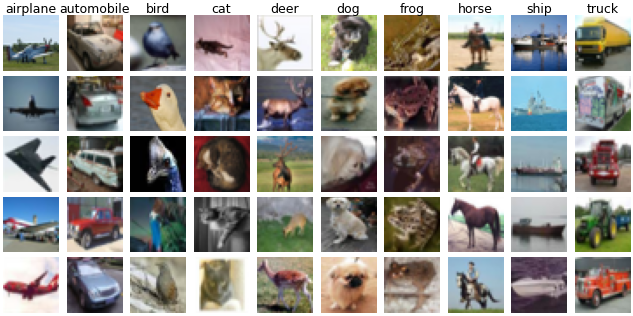

In [9]:
#display some random images for each label
# Plot a random image from each category
def show_category_samples(rows=5):
    displayed_indices = []
    plt.figure(figsize=(20, 2 * rows), dpi=32)
    for row in range(rows):
         for i in range(10):
            # Find the indices of the images that belong to class i and have not been displayed yet
            indices = np.setdiff1d(np.where(y_train == i)[0], displayed_indices)
            # Choose a random index from these indices
            index = np.random.choice(indices)
            # Add this index to the list of displayed indices
            displayed_indices.append(index)
            # Plot the image
            plt.subplot(rows, 10, row * 10 + i + 1)
            plt.imshow(x_train[index])
            if row == 0:
                plt.title(cifar10_class_names[i],fontdict = {'fontsize' : 28})
            plt.axis('off')   
    plt.tight_layout()
    plt.show()
        
show_category_samples()

### Data Format

In [10]:
print(f"Each image is represented as a 3D  array {x_train[0].shape}")
print(f"This translates to  {x_train[0].shape[0]} x {x_train[0].shape[1]} X,Y pixel positions")
print(f"with each pixel having {x_train[0].shape[2]} 8bit values for RGB colors which are the RGB Pixel Intensity")
print(f"e.g. the pixel in row 0 column 0 of the first image has an RGB value of {x_train[0][1][2]}")  


Each image is represented as a 3D  array (32, 32, 3)
This translates to  32 x 32 X,Y pixel positions
with each pixel having 3 8bit values for RGB colors which are the RGB Pixel Intensity
e.g. the pixel in row 0 column 0 of the first image has an RGB value of [6 6 6]


### Data Preprocessing

#### Normalisation

In [3]:
# Each RGB value is an 8 bit inteteger which means that each pixel can take values from 0 to 255 
# We need to scale (normalise) pixel values to be between 0 and 1 by dividing with the maximum value 
# to turn it into a value between 0 and 1   this  will suit the neural networks activation fuctiion
# we turn them in to floats before the division, for better precision - otherwise we will only have 1s and 0s
x_train_norm, x_val_norm, x_test_norm = x_train.astype("float32") / 255.0,  x_val.astype("float32") / 255.0, x_test.astype("float32") / 255.0
print("Data Ranges - ***Before Preprocessing***")
print(f"Training Set:\t Min:{np.min(x_train)} \t\t Median:{np.median(x_train)} \t\t\t Max:{np.max(x_train)}")
print(f"Validation Set:\t Min:{np.min(x_val)} \t\t Median:{np.median(x_val)} \t\t\t Max:{np.max(x_val)}")
print(f"Test Set:\t Min:{np.min(x_test)} \t\t Median:{np.median(x_test)} \t\t\t Max:{np.max(x_test)}")
print("Data Ranges - ***After Preprocessing***")
print(f"Training Set:\t Min:{np.min(x_train_norm)} \t Median:{np.median(x_train_norm)} \t Max:{np.max(x_train_norm)}")
print(f"Validation Set:\t Min:{np.min(x_val_norm)} \t Median:{np.median(x_val_norm)} \t Max:{np.max(x_val_norm)}")
print(f"Test Set:\t Min:{np.min(x_test_norm)} \t Median:{np.median(x_test_norm)} \t Max:{np.max(x_test_norm)}")
      

Data Ranges - ***Before Preprocessing***
Training Set:	 Min:0 		 Median:117.0 			 Max:255
Validation Set:	 Min:0 		 Median:116.0 			 Max:255
Test Set:	 Min:0 		 Median:117.0 			 Max:255
Data Ranges - ***After Preprocessing***
Training Set:	 Min:0.0 	 Median:0.4588235318660736 	 Max:1.0
Validation Set:	 Min:0.0 	 Median:0.45490196347236633 	 Max:1.0
Test Set:	 Min:0.0 	 Median:0.4588235318660736 	 Max:1.0


We can plot the frequency distribution and confirm that normalisation scales the values without affecting the dataset distribution

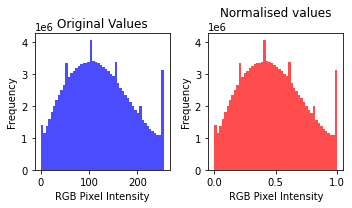

In [4]:
# Create a new figure
plt.figure(figsize=(5,3 ))

# Create a histogram for x_train
plt.subplot(1, 2, 1)
plt.hist(x_train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Original Values')
plt.xlabel('RGB Pixel Intensity')
plt.ylabel('Frequency')

# Create a histogram for x_train_norm
plt.subplot(1, 2, 2)
plt.hist(x_train_norm.flatten(), bins=50, color='red', alpha=0.7)
plt.title('Normalised values')
plt.xlabel('RGB Pixel Intensity')
plt.ylabel('Frequency')

# Show the figure
plt.tight_layout()
plt.show()


#### One-Hot Encoding

In [5]:
# we also apply one-hot encoding to our target labels turning each class number into a binary vector
# and use the target label as an index to turn on that bit with 1.
y_train_encoded = keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = keras.utils.to_categorical(y_val, num_classes)
y_test_encoded = keras.utils.to_categorical(y_test, num_classes)

def preview_label_encoding(num_items_to_preview=5):
    print("target label \t\t encoded label")
    for i in range(num_items_to_preview):
        print(f"{y_train[i][0]}\t\t->\t{y_train_encoded[i].astype('int')}" )

preview_label_encoding()


target label 		 encoded label
7		->	[0 0 0 0 0 0 0 1 0 0]
8		->	[0 0 0 0 0 0 0 0 1 0]
2		->	[0 0 1 0 0 0 0 0 0 0]
4		->	[0 0 0 0 1 0 0 0 0 0]
8		->	[0 0 0 0 0 0 0 0 1 0]


### Algorithm Selection and Builiding our CNN Network for Image Recognition 

We will be using a CNN because they have been proven to work well with Image recognition.Below we define the architecture

In [6]:
# Creating a sequential model and add convolutional layers to it. Convolutions act as sliding magnifying glasses detecting patterns 
# starting from simple ones eg lines and adding them to create more complex ones (objects) as we add more and more convolutional layers
# We use pooling layers (MaxPooling2D) to reduce the quality and get rid of noise, highlighting features and avoid overffiting
# Batch Normalisation layers use  a technique to improve perfomance and stability whereas Dropour layers apply regularisation to avoid overfitting
# Finally, we flatten the 3D outputs of convolutions to feed them into the more general prupose fully connected (Dense) layers.
# This lears will help perfom the classification using the softmax activation function at the end.
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [7]:
### set the optimisation and loss function suitable to the job, metrics to use during training, and compile the model
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

### Model Training

**If your environment does not have a good GPU, training this model can take a long time. You can review the code and jump to the evaluation section, where we load a saved pre-trained model**

In [8]:
#set the hyperparamters eg batch_size and epochs and train the model, using the test data for validation
history = model.fit(x_train_norm, y_train_encoded, batch_size=64, epochs=100,
                    validation_data=(x_val_norm, y_val_encoded))


Epoch 1/100


2023-07-22 08:55:25.032641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


625/625 [==============================] - 25s 31ms/step - loss: 1.8264 - accuracy: 0.3860 - val_loss: 1.3236 - val_accuracy: 0.5246
Epoch 2/100
625/625 [==============================] - 18s 29ms/step - loss: 1.2696 - accuracy: 0.5451 - val_loss: 1.1597 - val_accuracy: 0.5868
Epoch 3/100
625/625 [==============================] - 18s 29ms/step - loss: 1.0862 - accuracy: 0.6162 - val_loss: 0.9131 - val_accuracy: 0.6717
Epoch 4/100
625/625 [==============================] - 18s 28ms/step - loss: 0.9636 - accuracy: 0.6605 - val_loss: 0.9353 - val_accuracy: 0.6634
Epoch 5/100
625/625 [==============================] - 18s 28ms/step - loss: 0.8841 - accuracy: 0.6886 - val_loss: 0.7638 - val_accuracy: 0.7344
Epoch 6/100
625/625 [==============================] - 19s 30ms/step - loss: 0.8166 - accuracy: 0.7142 - val_loss: 0.7736 - val_accuracy: 0.7365
Epoch 7/100
625/625 [==============================] - 20s 32ms/step - loss: 0.7710 - accuracy: 0.7330 - val_loss: 0.7544 - val_accuracy: 0.73

Text(0.5, 1.0, 'Accuracy Curves')

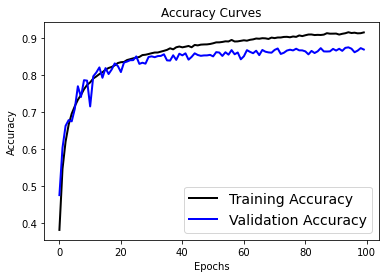

In [12]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

In [13]:
# save the model so that we can evaluate it (and skip training if our environment is not powerful enough)
model.save(model_filename)

### Model Evaluation

In [14]:
#load and test pretrained  model
model =  tf.keras.models.load_model(model_filename,compile=False)

In [15]:
# Making the Predictions
y_pred = model.predict(x_test_norm)

313/313 [==============================] - 1s 1ms/step


In [18]:
# Converting the predictions into label index 
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_cnn = accuracy_score(y_test, y_pred_labels)
print(f"CNN Accuracy: {accuracy_cnn:.2f}", )



# utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", display_labels=cifar10_class_names)
    fig = cm_display.ax_.get_figure() 
    fig.set_figwidth(9)
    fig.set_figheight(9) 



# Show confusion matrix for the decision tree
show_confusion_matrix(y_test, y_pred_labels)

CNN Accuracy: 0.87


AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

### Model Deployment

#### Deploy Saved Model for the  REST Inference  Service 

We deploy the saved model to the *deployed_models* directory, which is used by the inference service. If a model has been deployed before, they will be renamed with a version appended to their filenames. eg *simple-cifar10.v1.h5* and be kept as backups and tracking purposes. 

*This deployment code is for educational purposes only and it is not for production. Use an MLOPs framework for production-grade pipeline*

In [13]:
import os
import shutil
import glob
import re

import os
import shutil
import glob
import re

def deploy_model(model_deployment_directory, file_name):        
    # Construct the destination file path
    destination_path = os.path.join(model_deployment_directory, file_name)
    
    # Check if a file with the same name already exists in the destination directory
    if os.path.exists(destination_path):
        # Find all versions of the file in the destination directory
        glob_pattern = os.path.join(model_deployment_directory, file_name.replace('.h5', '*.h5'))

        # Find all versions of the file in the destination directory
        existing_versions = glob.glob(glob_pattern)

        # Extract the version numbers from the file names
        version_numbers = []
        for file in existing_versions:
            match = re.search('v(\d+).h5$', file)
            if match:
                version_numbers.append(int(match.group(1)))

        # Determine the version number for the existing file
        if version_numbers:
            new_version_number = max(version_numbers) + 1
        else:
            new_version_number = 1

        # Construct the new file name with the version number for the existing file
        new_file_name = file_name.replace('.h5', '') + '.v' + str(new_version_number) + '.h5'
        new_destination_path = os.path.join(model_deployment_directory, new_file_name)

        # Rename the existing file
        os.rename(destination_path, new_destination_path)
        print(f"Existing model renamed to: {new_destination_path}")

    # Copy the new file with its original name
    shutil.copy(file_name, destination_path)
    print(f"New model deployed to: {destination_path}")
        
# Directory where the file will be copied
model_deployment_directory = 'deployed_models'

# Check if model deployment directory exists, if not, create it
if not os.path.exists(model_deployment_directory):
    os.makedirs(model_deployment_directory)

deploy_model(model_deployment_directory, model_filename)



Existing model renamed to: deployed_models/simple-cifar10.v3.h5
New model deployed to: deployed_models/simple-cifar10.h5
